### CNN-RNN for genre classification. 

* conducting an experiment with CNN-RNN model
* visualizing the preformance of the CNN layers


In [6]:
pip install keract

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

import keract

### Define representation of genres

Each genre is assigned a number, since the neural network will output a number [not a word]. 

In [2]:
dict_genres = {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 
               'Instrumental': 4,'International': 5, 'Pop': 6, 'Rock': 7}


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


### Load the dataset 

The dataset can be found at https://drive.google.com/drive/folders/1ZtwC9ralBSs6wzP-IylX5uh1wD1YXLh9?usp=sharing

Instructions: you can manually download it to your computer, or use wget from a command line. \
If you are using colab, you can copy the files to your drive and then mount the drive using google colab drive command: \
from google.colab import drive \
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [3]:
data_path=os.getcwd()
npzfile = np.load('{}/shuffled_train.npz'.format(data_path))
X_train = npzfile['arr_0']   # Audio samples
y_train = npzfile['arr_1']   # Genre labels
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [4]:
npzfile = np.load('{}/shuffled_valid.npz'.format(data_path))
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


### Show one data sample:

International


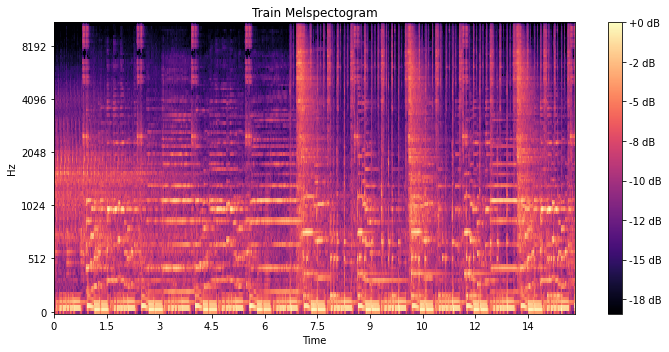

In [8]:
one_arbitrary_sample = 50
spectogram = X_train[one_arbitrary_sample]
genre = np.argmax(y_train[one_arbitrary_sample])
print(reverse_map[genre])

plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Train Melspectogram')
plt.tight_layout()

### Summary of five random generated samples from each genere:

| Genre | Use all Freq Domain| Smear Freq Domain | Smear Time Domain | Gap Size in Time Domain | Gap Size in Freq Domain | Sharpness | Freq duplications |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Electronic   | Yes | Yes | Yes | Small | Small | No | No |
| Experimental | No  | Yes | Yes | Small | Small | Yes | Yes |
| Folk         | Yes | Yes | Yes | Small | Small | No | Yes |
| Hip-Hop      | Yes | Yes | Yes | Small | Small | No | Yes |
| Instrumental | No  | No  | Yes | Large | Small | Yes | Yes |
| International| Yes | Yes | Yes | Small | Small | No | Yes |
| Pop          | Yes | Yes | Yes | Small | Small | No | No |
| Rock         | Yes | Yes | Yes | Small | Small | No | Yes |

In [10]:
num_of_samples=5
counters_bank={}
i=0
while i < len(dict_genres)*num_of_samples:
    one_arbitrary_sample = np.random.randint(X_train.shape[0])
    spectogram = X_train[one_arbitrary_sample]
    genre = np.argmax(y_train[one_arbitrary_sample])
    if genre not in counters_bank:
        counters_bank[genre] = 1
    if genre in counters_bank:
        if counters_bank[genre] <= 3:
            plt.figure(figsize=(10, 5))
            librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Melspectogram_{}_{}'.format(reverse_map[genre],counters_bank.get(genre)))
            plt.tight_layout()
            plt.savefig('TrainSpectrogtrams//{}_{}.png'.format(reverse_map[genre],counters_bank.get(genre)), dpi=600)
            counters_bank[genre] += 1
            i+=1

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 720x360 with 0 Axes>

### Convolution Layer

A convolution is a kernel (a matrix of weights; also reffered to as a mask) that is applied across an image to extract spatial information by factoring each point's neighbors.  

Classical image processing uses custom kernels that can extract key features that can be used for problems like edge detection. Refer to this Wiki article for a few examples.

In deep learning, we build a model to learn more complicated kernels that can extract more specialized information.

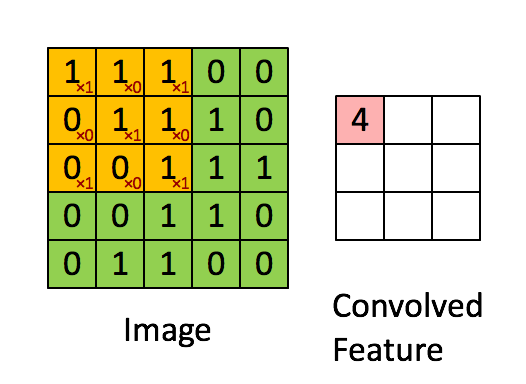

### Padding - Prevent image Shrink

Given a convolution layer with $f$ filters, ($k_x$ x $k_y$) kernel, and ($s_x$ x $s_y$) stride, the output dimension with/without padding (ie "valid" vs "same") on an ($n_x$ x $n_y$) image:

``` 
Output height = (ny + 2pd - ky) / sy + 1

Output width = (nx + 2pd - kx) / sx + 1

stride - represents the amount of movment or the 'jump' of the filter on the image.

pd=padding size

if padding is valid (means no padding) then pd = 0

 ```

### Pooling Layer

A pool is a very similar to a convolution layer. It is filter that is applied across the output of the convolution layer to reduce dimensionality and mitigate overfitting by summarizing the convolution results.

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network.
The pooling layer summarises the features present in a region of the feature map generated by a convolution layer. So, further operations are performed on summarised features instead of precisely positioned features generated by the convolution layer. This makes the model more robust to variations in the position of the features in the input image. 

For this demonstration, I will be using max pooling. another method is Average Pooling

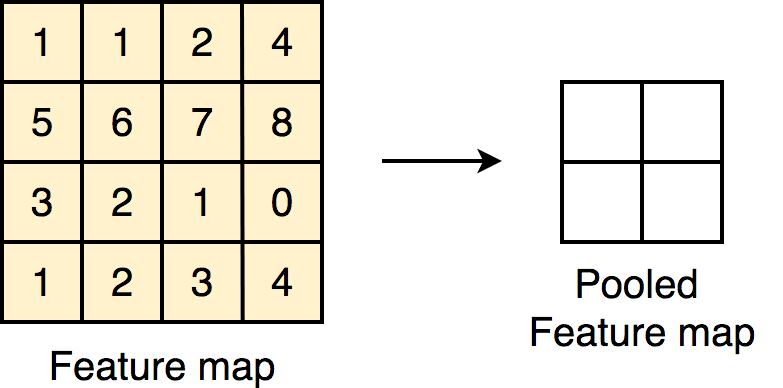

Given a pooling layer ($p_x$ x $p_y$) pool and ($s_x$ x $s_y$) stride, the output dimension with/without padding (ie "valid" vs "same") on an ($n_x$ x $n_y$) image:

``` 

Output height = (ny + py + 2pd) / sy + 1

Output width = (nx + px + 2pd) / sx + 1


 ```

#### Parallel CNN - RNN Model

Since music has temporal features, it is obvious to use a RNN, but we saw from the melspectograms that there are also visual features that a CNN might learn. Our motivation is to try to combine both models through concatenation to extract both temporal and spatial features. 

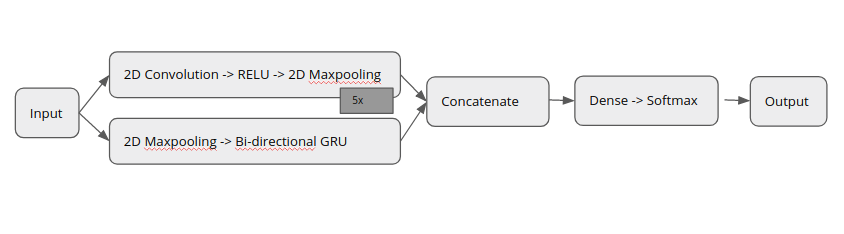

In [21]:
# The number of possible predicted classes
num_classes = 8

# The number of features in a single data input (frequency components)
n_features = X_train.shape[2]

# The length of an input sample (in seconds)
n_time = X_train.shape[1]

In [22]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks    
    conv_1 = Conv2D(filters=16, kernel_size=(3,1), strides=1,
                    padding='valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D((2,2))(conv_1)

    conv_2 = Conv2D(filters=16, kernel_size=(3,1), strides=1,
                padding='valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D((2,2))(conv_2)

    conv_3 = Conv2D(filters=16, kernel_size=(3,1), strides=1,
            padding='valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D((2,2))(conv_3)

    conv_4 = Conv2D(filters=16, kernel_size=(3,1), strides=1,
        padding='valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D((2,2))(conv_4)

    conv_5 = Conv2D(filters=16, kernel_size=(3,1), strides=1,
        padding='valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D((2,2))(conv_5)
    
    flatten1 = Flatten()(pool_5)
    
    ### Recurrent Block
    lstm_count = 64
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D((4,2), name = 'pool_lstm')(layer)
    
    # Embedding layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = RMSprop(learning_rate=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    return model

In [23]:
n_frequency = 128
n_frames = 640
input_shape = (n_frames, n_frequency, 1)
model_input = Input(input_shape, name='input')
model = conv_recurrent_model_build(model_input)

Building model...


In [24]:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input (InputLayer)             [(None, 640, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 638, 128, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 319, 64, 16)  0          ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 317, 64, 32)  1568        ['max_pooling2d_5[0][0]']        
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 158, 32, 32)  0          ['conv_2[0][0]']                 
                                                                                                  
 conv_3 (Conv2D)                (None, 156, 32, 64)  6208        ['max_pooling2d_6[0][0]']        
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 78, 16, 64)  0           ['conv_3[0][0]']                 
                                                                                                  
 conv_4 (Conv2D)                (None, 76, 16, 64)   12352       ['max_pooling2d_7[0][0]']        
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 38, 8, 64)   0           ['conv_4[0][0]']                 
                                                                                                  
 conv_5 (Conv2D)                (None, 36, 8, 64)    12352       ['max_pooling2d_8[0][0]']        
                                                                                                  
 pool_lstm (MaxPooling2D)       (None, 160, 64, 1)   0           ['input[0][0]']                  
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 18, 4, 64)   0           ['conv_5[0][0]']                 
                                                                                                  
 lambda_1 (Lambda)              (None, 160, 64)      0           ['pool_lstm[0][0]']              
                                                                                                  
 flatten_1 (Flatten)            (None, 4608)         0           ['max_pooling2d_9[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         49920       ['lambda_1[0][0]']               
 )                                                                                                
                                                                                                  
 concat (Concatenate)           (None, 4736)         0           ['flatten_1[0][0]',              
                                                                  'bidirectional_1[0][0]']        
                                                                                                  
 preds (Dense)                  (None, 8)            37896       ['concat[0][0]']                 
                                                                                                  
==================================================================================================
Total params: 120,360
Trainable params: 120,360
Non-trainable params: 0
__________________________________________________________________________________________________
None

IndentationError: unexpected indent (3485223515.py, line 3)

In [25]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 640
    
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)  ### Step 1
    
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=64, epochs=5,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list) ### Step 2
    
    '''
    test_accuracy = model.eval(x_test, y_test)   ### Step 3
    '''

    return model, history

In [26]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [27]:
model, history = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Training...
Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 1.9513 - accuracy: 0.2623
Epoch 1: val_accuracy improved from -inf to 0.32000, saving model to ./models/parallel/weights.best.h5
100/100 [==============================] - 59s 559ms/step - loss: 1.9513 - accuracy: 0.2623 - val_loss: 1.8364 - val_accuracy: 0.3200 - lr: 5.0000e-04
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 1.7718 - accuracy: 0.3447
Epoch 2: val_accuracy improved from 0.32000 to 0.33625, saving model to ./models/parallel/weights.best.h5
100/100 [==============================] - 57s 572ms/step - loss: 1.7718 - accuracy: 0.3447 - val_loss: 1.7295 - val_accuracy: 0.3363 - lr: 5.0000e-04
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 1.6864 - accuracy: 0.3830
Epoch 3: val_accuracy improved from 0.33625 to 0.37375, saving model to ./models/parallel/weights.best.h5
100/100 [==============================] - 57s 567ms/step - loss: 1.

### Results


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


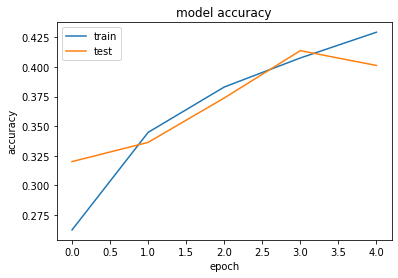

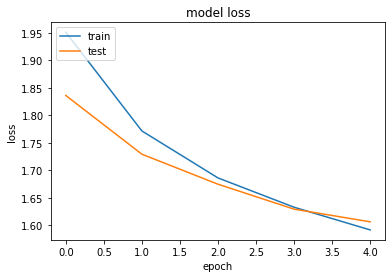

In [28]:
show_summary_stats(history)

In [29]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

25/25 [==============================] - 3s 93ms/step
(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.31      0.76      0.44       100
 Experimental       0.26      0.28      0.27       100
         Folk       0.51      0.62      0.56       100
      Hip-Hop       0.57      0.08      0.14       100
 Instrumental       0.24      0.12      0.16       100
International       0.56      0.51      0.53       100
          Pop       0.19      0.10      0.13       100
         Rock       0.63      0.74      0.68       100

     accuracy                           0.40       800
    macro avg       0.41      0.40      0.36       800
 weighted avg       0.41      0.40      0.36       800



## Model Performance Description 
Model performs well - it can easily seen from accuracy graphs that after 10 epochs it has ~50% accuraty rate on train set and ~45% on test set which are higher results than we expect in "natrual" eight generes classification when we expect accuracy of 12.5%.

We can learn from loss curves - both curves are convergin. it means less error as we perform more epochs and it keeps monotonous decrease which means that the model is learning the data well and keeps learning it.
curves are not exploding - no anomalous or damaged data.

No Overfit - model shows similar performance on test and train set.

### Visualizing the Model

1
input (1, 640, 128, 1) 


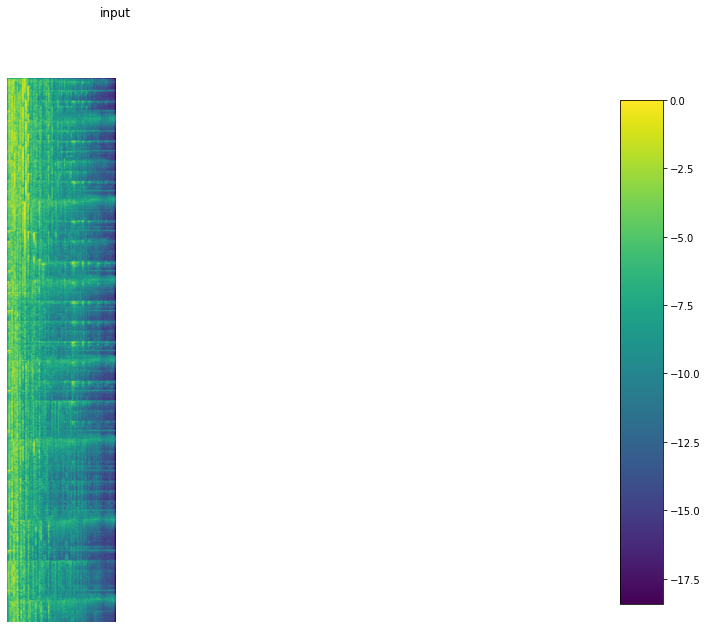

conv_1 (1, 638, 128, 16) 


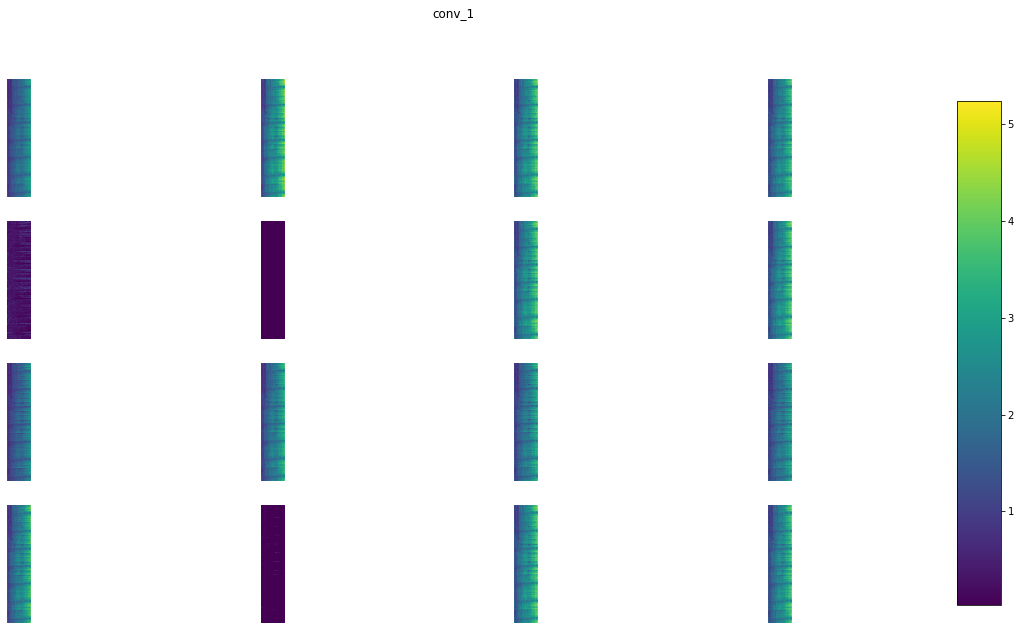

max_pooling2d_20 (1, 319, 64, 16) 


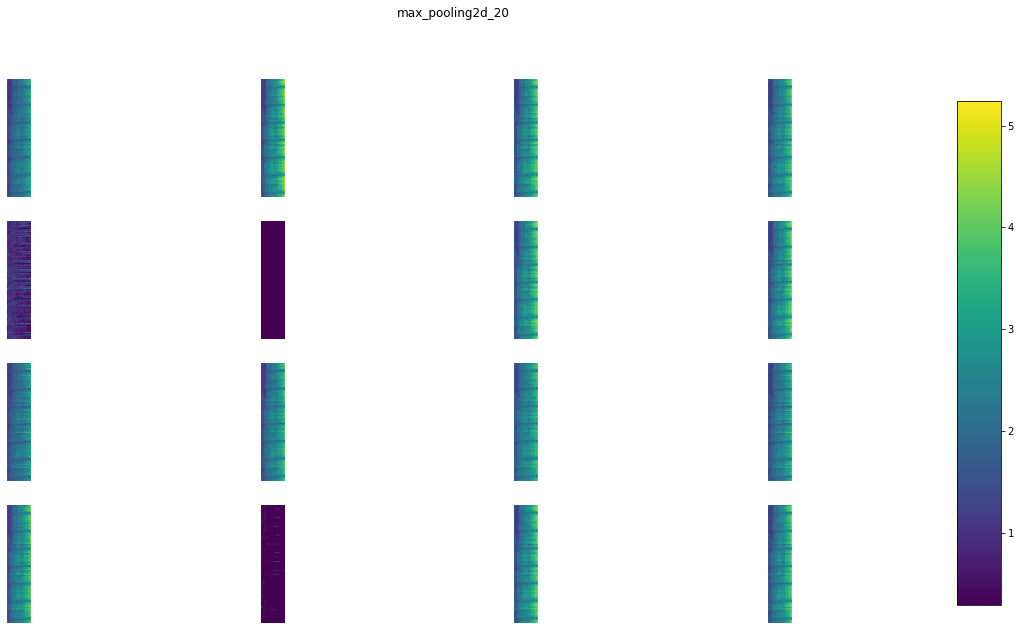

conv_2 (1, 317, 64, 16) 


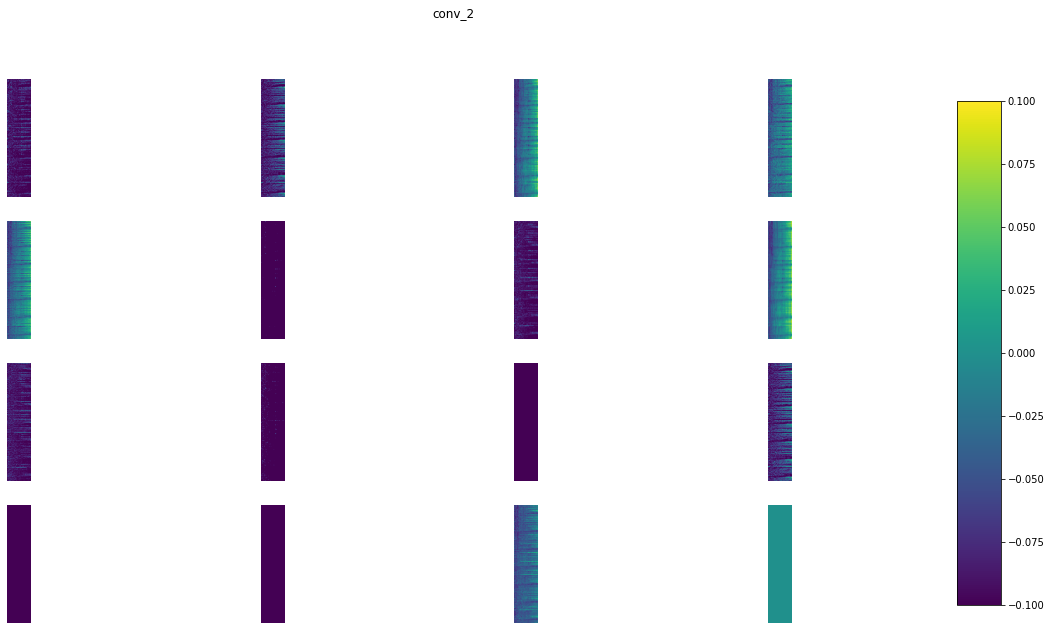

max_pooling2d_21 (1, 158, 32, 16) 


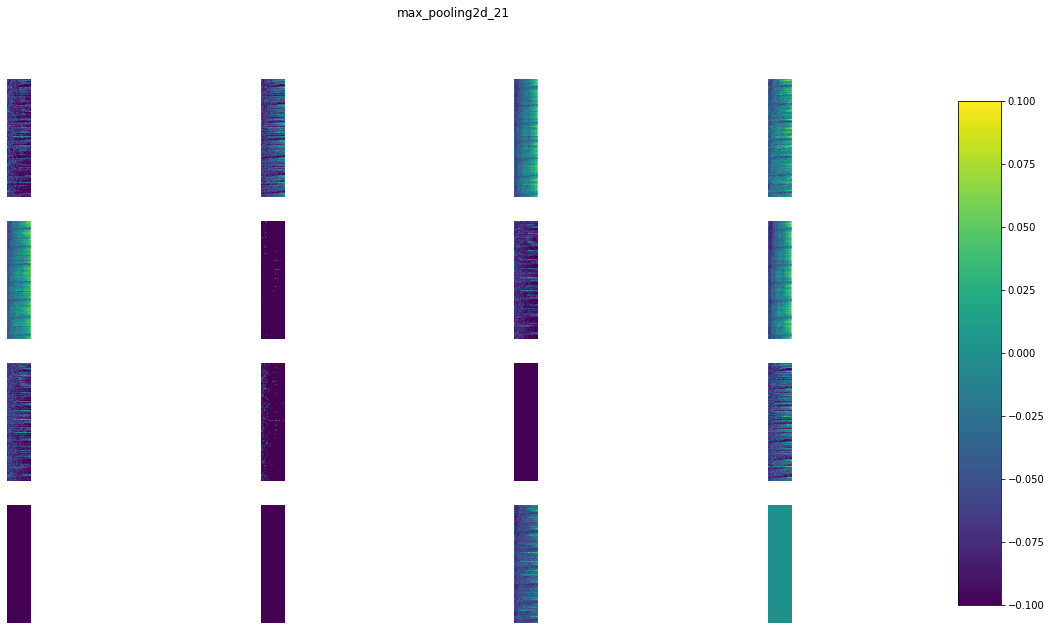

conv_3 (1, 156, 32, 16) 


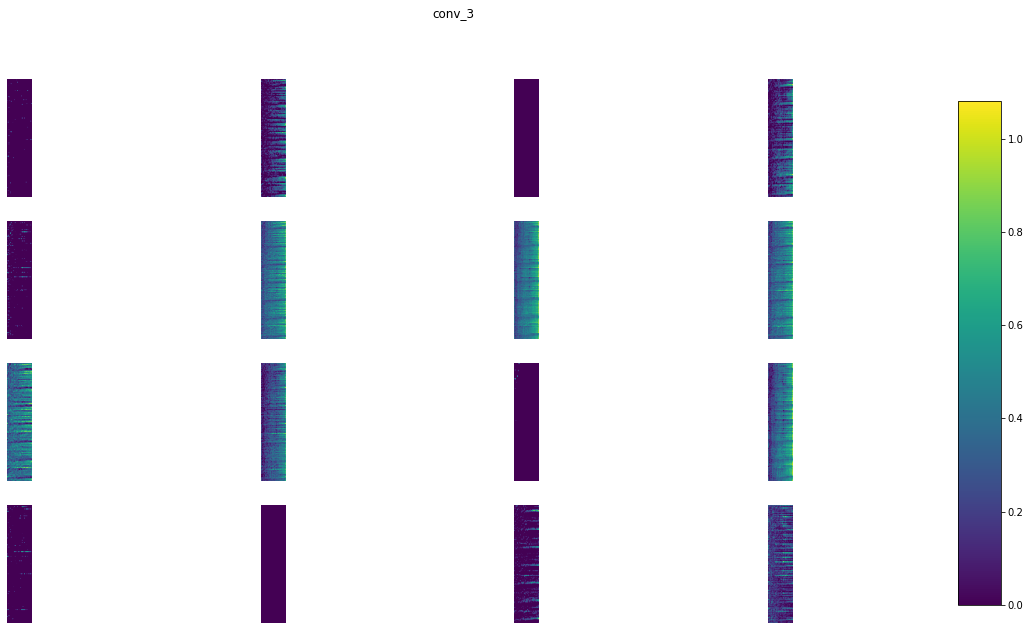

max_pooling2d_22 (1, 78, 16, 16) 


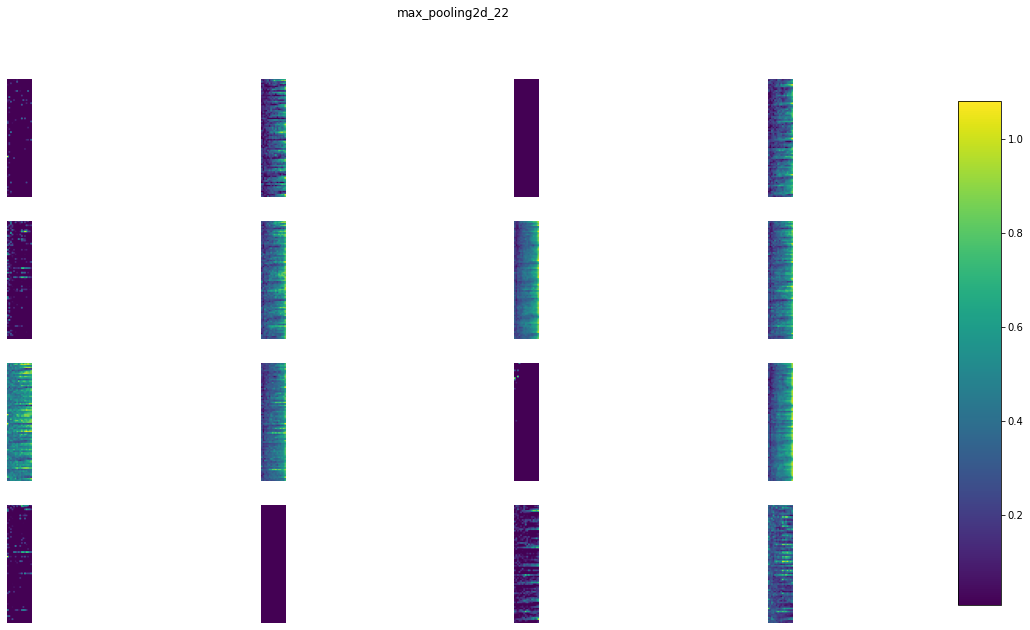

conv_4 (1, 76, 16, 16) 


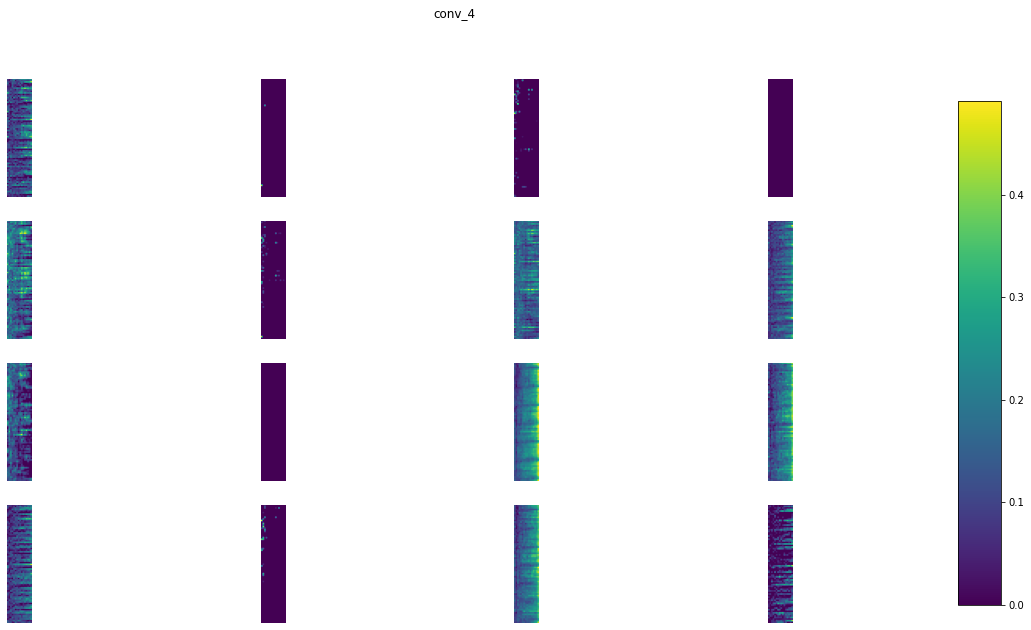

max_pooling2d_23 (1, 38, 8, 16) 


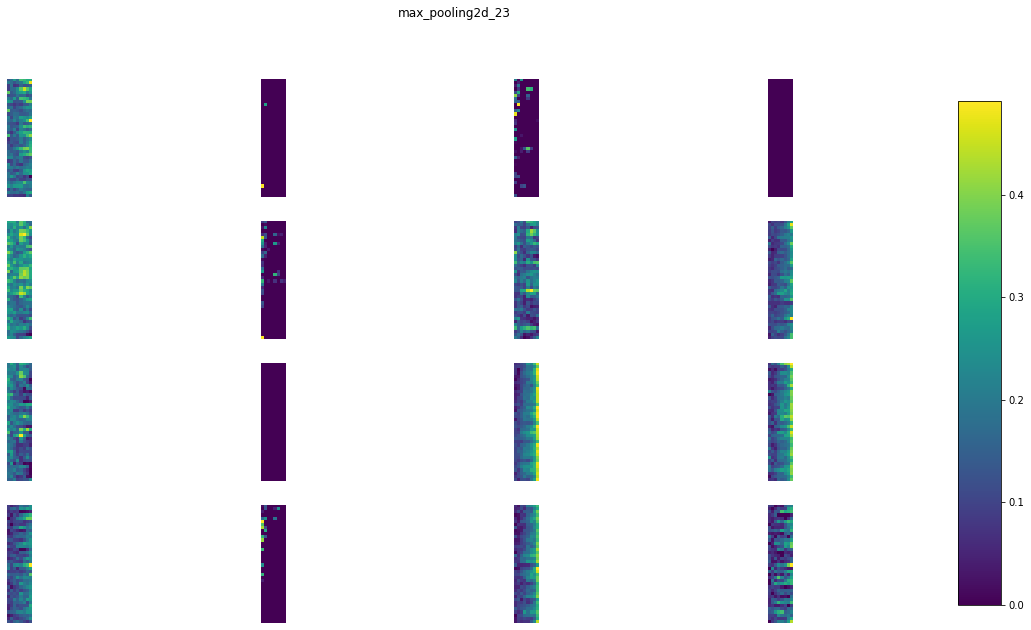

conv_5 (1, 36, 8, 16) 


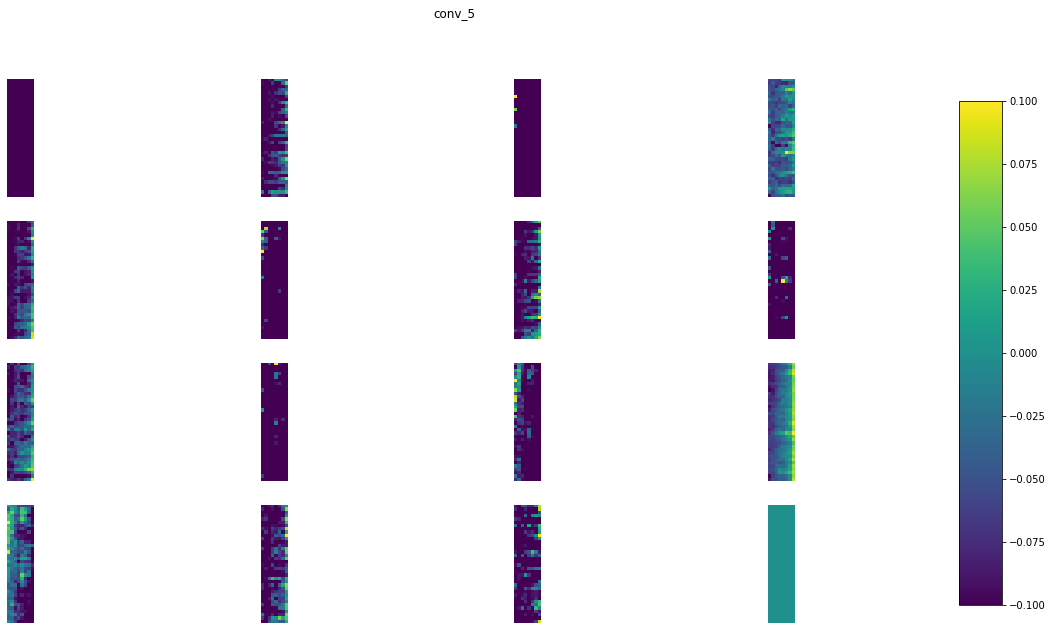

pool_lstm (1, 160, 64, 1) 


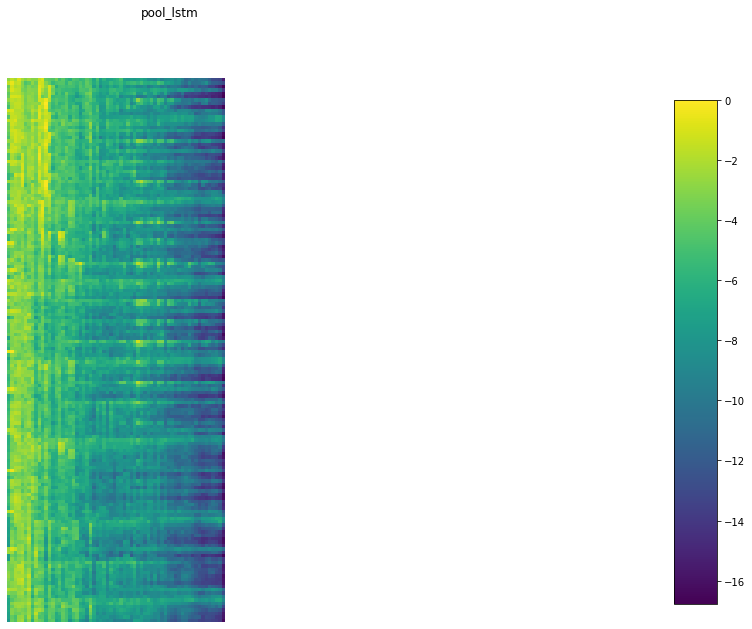

max_pooling2d_24 (1, 18, 4, 16) 


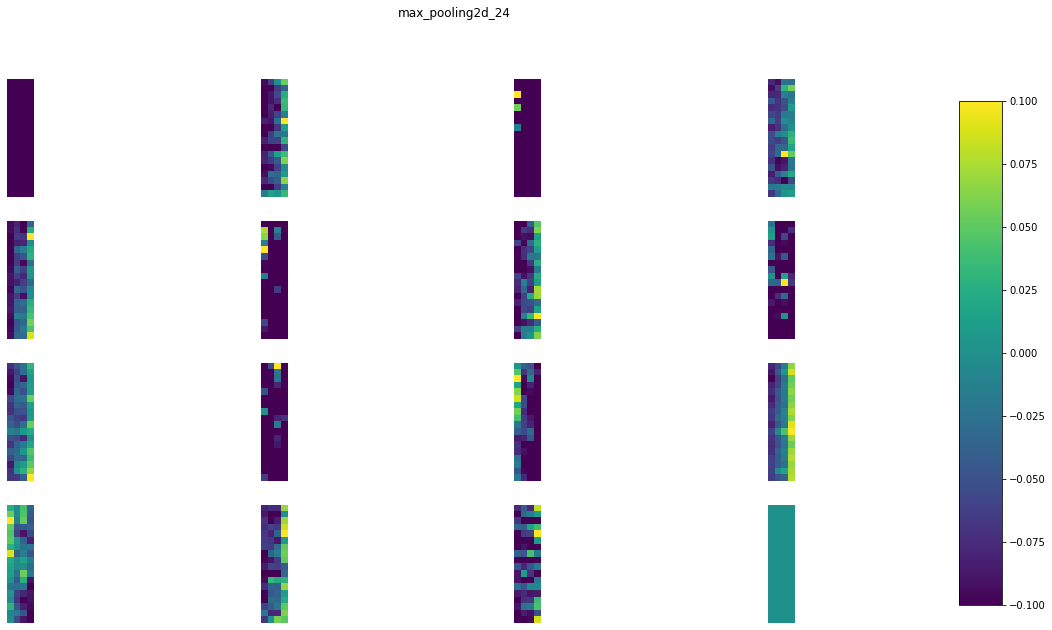

lambda_4 (1, 160, 64) 


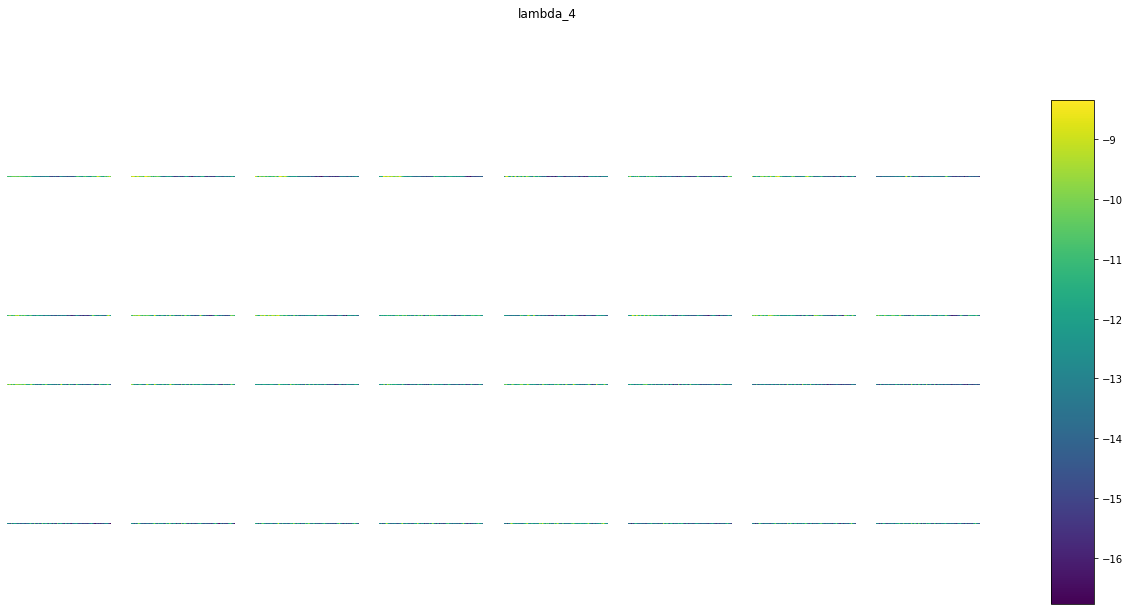

flatten_4 (1, 1152) 


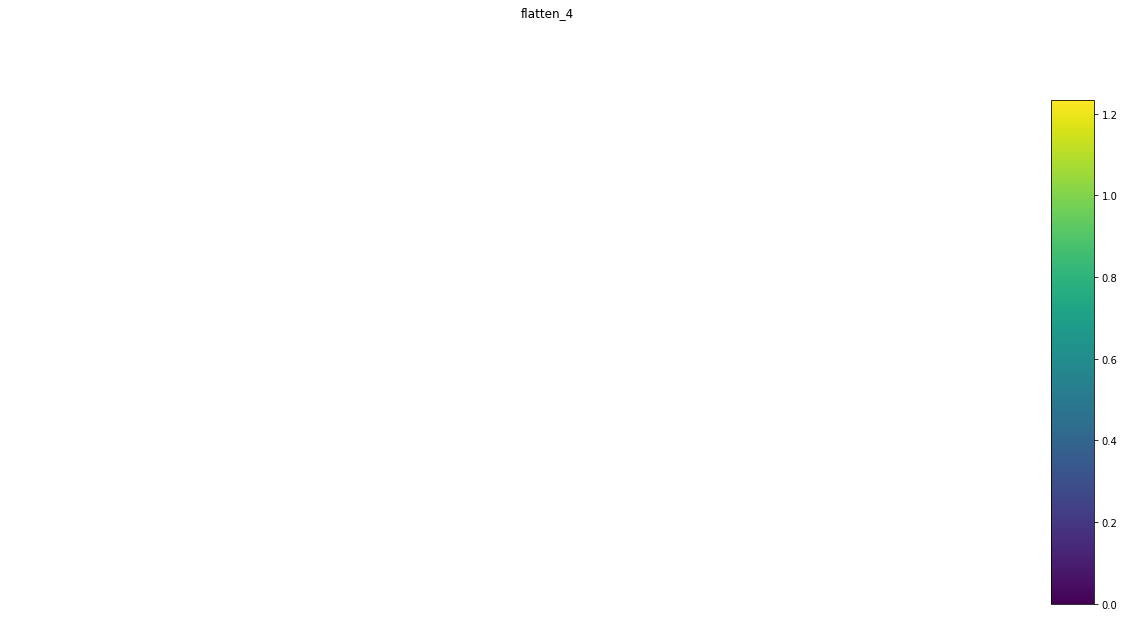

bidirectional_4 (1, 128) 


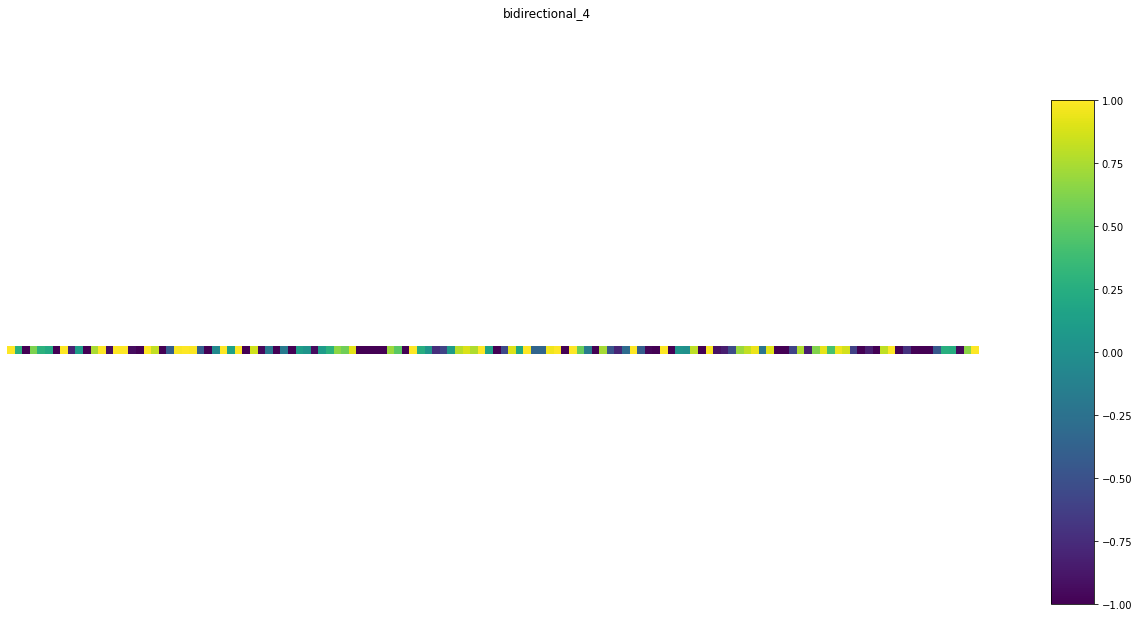

concat (1, 1280) 


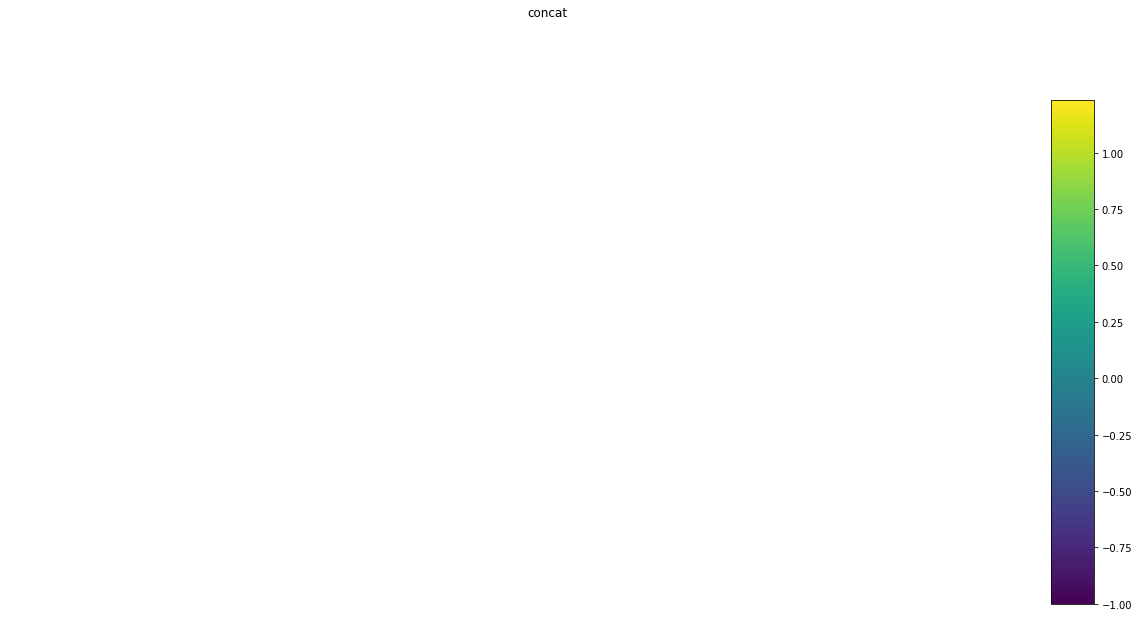

preds (1, 8) 


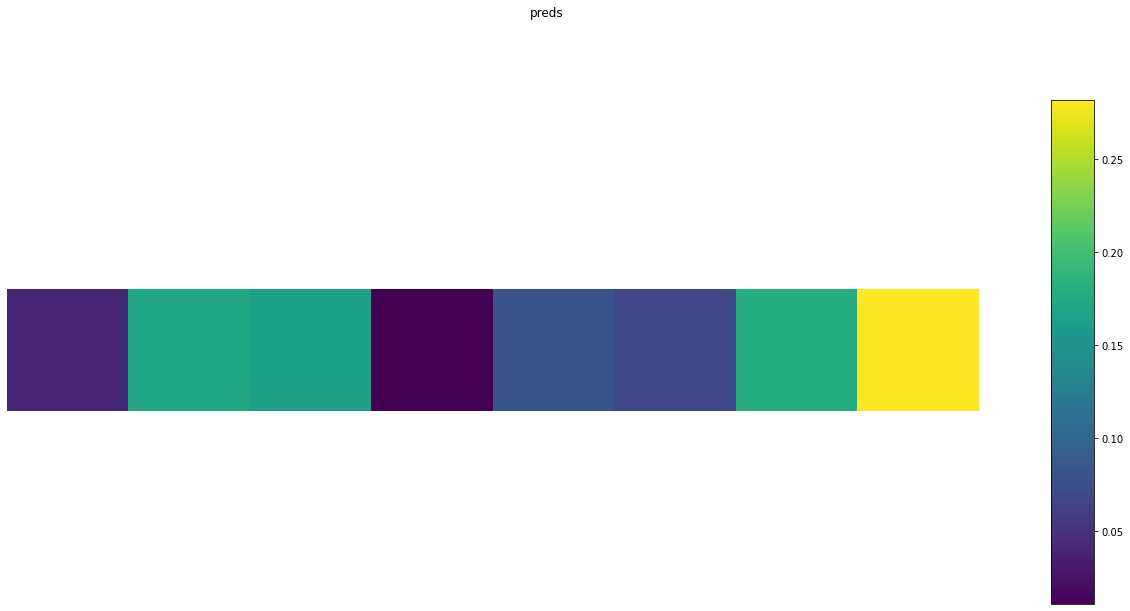

In [30]:
one_arbitrary_sample = 0
sample = X_valid[one_arbitrary_sample:one_arbitrary_sample+1]
genre = np.argmax(y_valid[one_arbitrary_sample])
print(genre)
activations = keract.get_activations(model, sample, layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
keract.display_activations(activations, cmap=None, save=False, data_format='channels_last', fig_size=(20, 10))